In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

In [5]:
df = pd.read_csv("./data/daily_hospitalized_patients.csv")
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,2017-04-01,30,1
1,2017-04-02,45,1
2,2017-04-03,65,1
3,2017-04-04,78,1
4,2017-04-05,71,1


In [6]:
df["ds"] = pd.to_datetime(df["ds"])

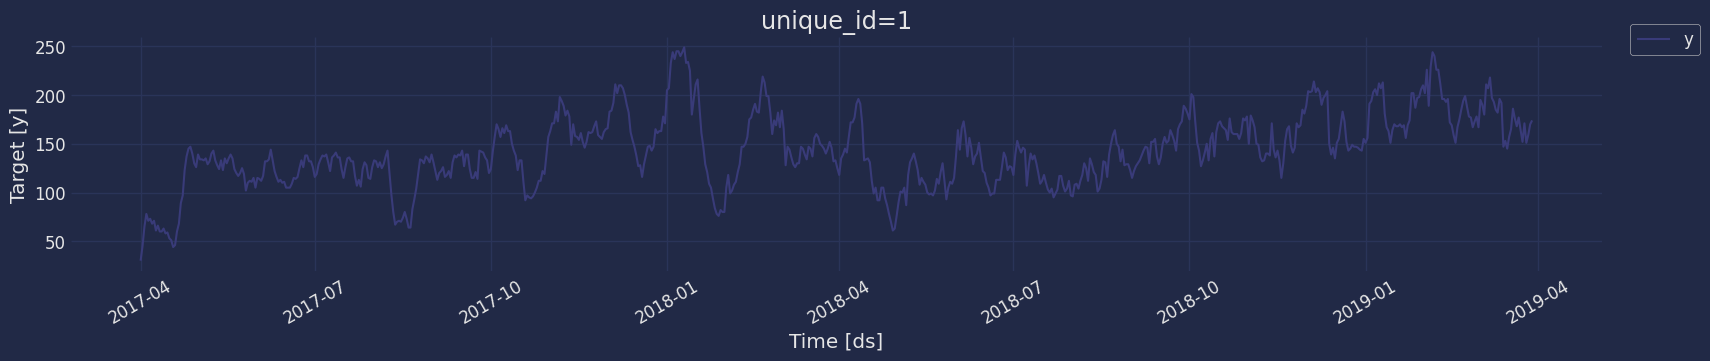

In [7]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

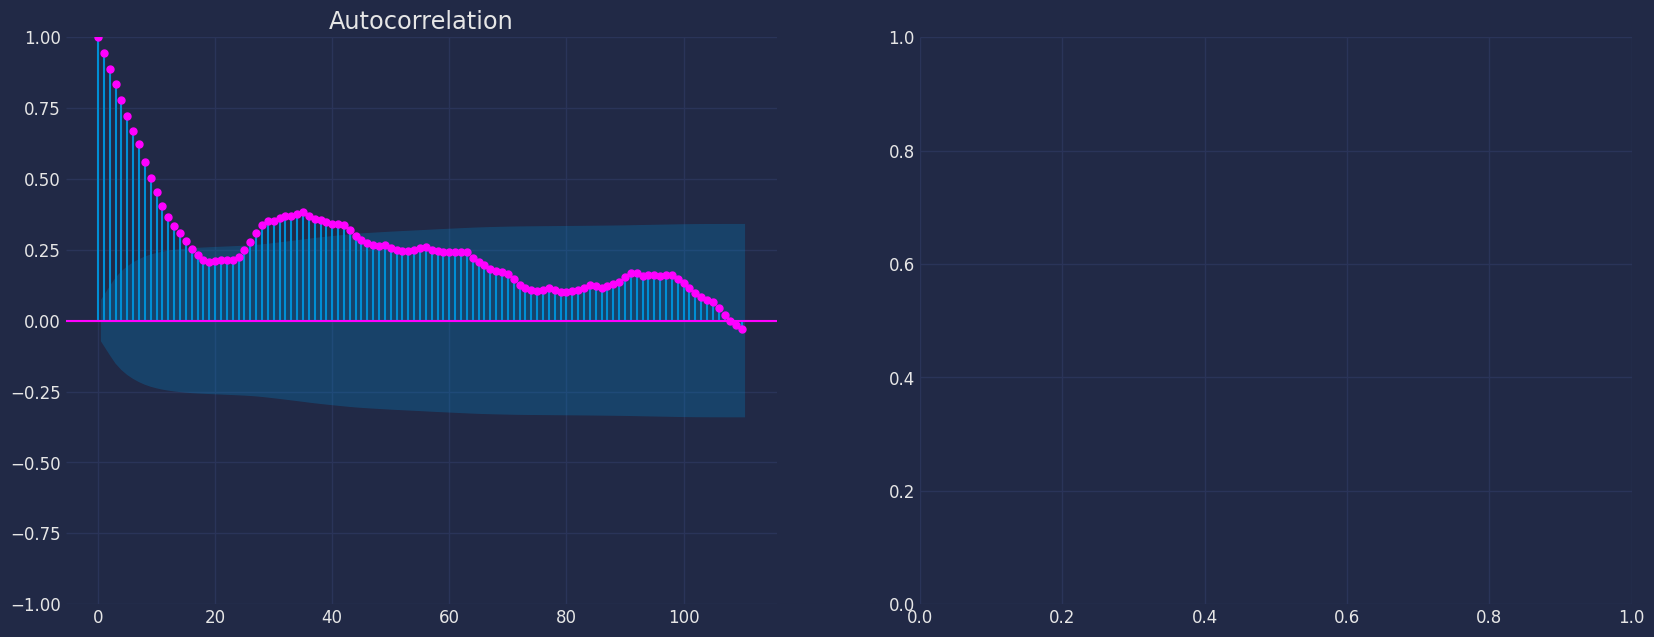

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=110, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# plot_pacf(df["y"],  lags=60, ax=axs[1],color="lime")
# axs[1].set_title('Partial Autocorrelation')

plt.show();

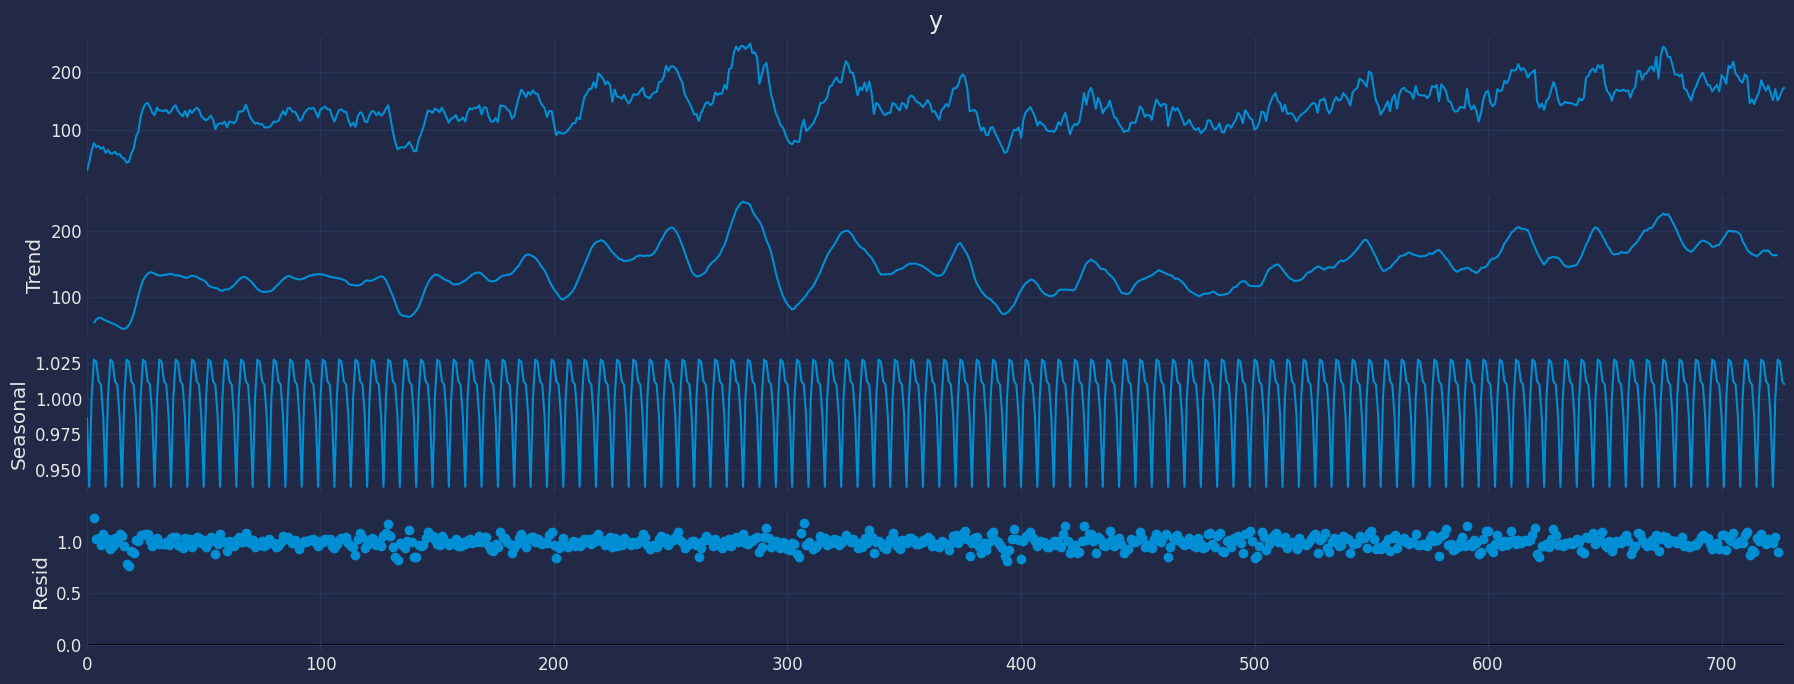

In [77]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "multiplicative", period=7)
a.plot();

In [59]:
Y_train_df = df[df.ds<='2019-01-01']
Y_test_df = df[df.ds>'2019-01-01']
Y_train_df.shape, Y_test_df.shape

((641, 3), (87, 3))

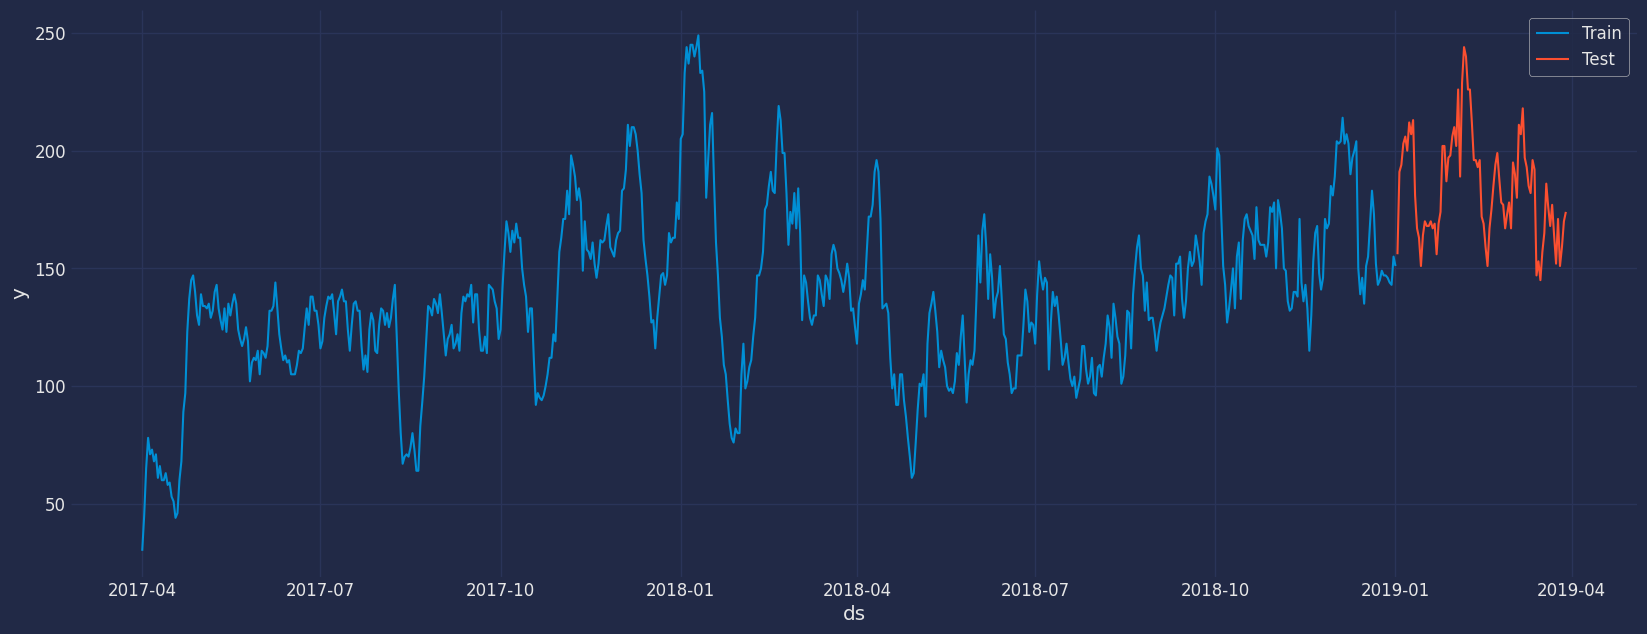

In [60]:
sns.lineplot(Y_train_df,x="ds", y="y", label="Train")
sns.lineplot(Y_test_df, x="ds", y="y", label="Test")
plt.show()

In [14]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

In [125]:
season_length = 21
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(d=1,D=1,season_length=season_length)]
sf = StatsForecast(models=models, freq='D')
sf.fit(df=Y_train_df)
arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,1,0)(2,1,1)[21]                   '

In [122]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(0, 0, 2, 0, 14, 1, 1)


In [82]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,0.030000
1,14.609126
2,18.245303
3,11.067508
4,-7.843194
...,...
636,1.455885
637,1.255291
638,1.303317
639,10.411001


C:\Users\Gaby\AppData\Local\Temp\ipykernel_172\3728362320.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


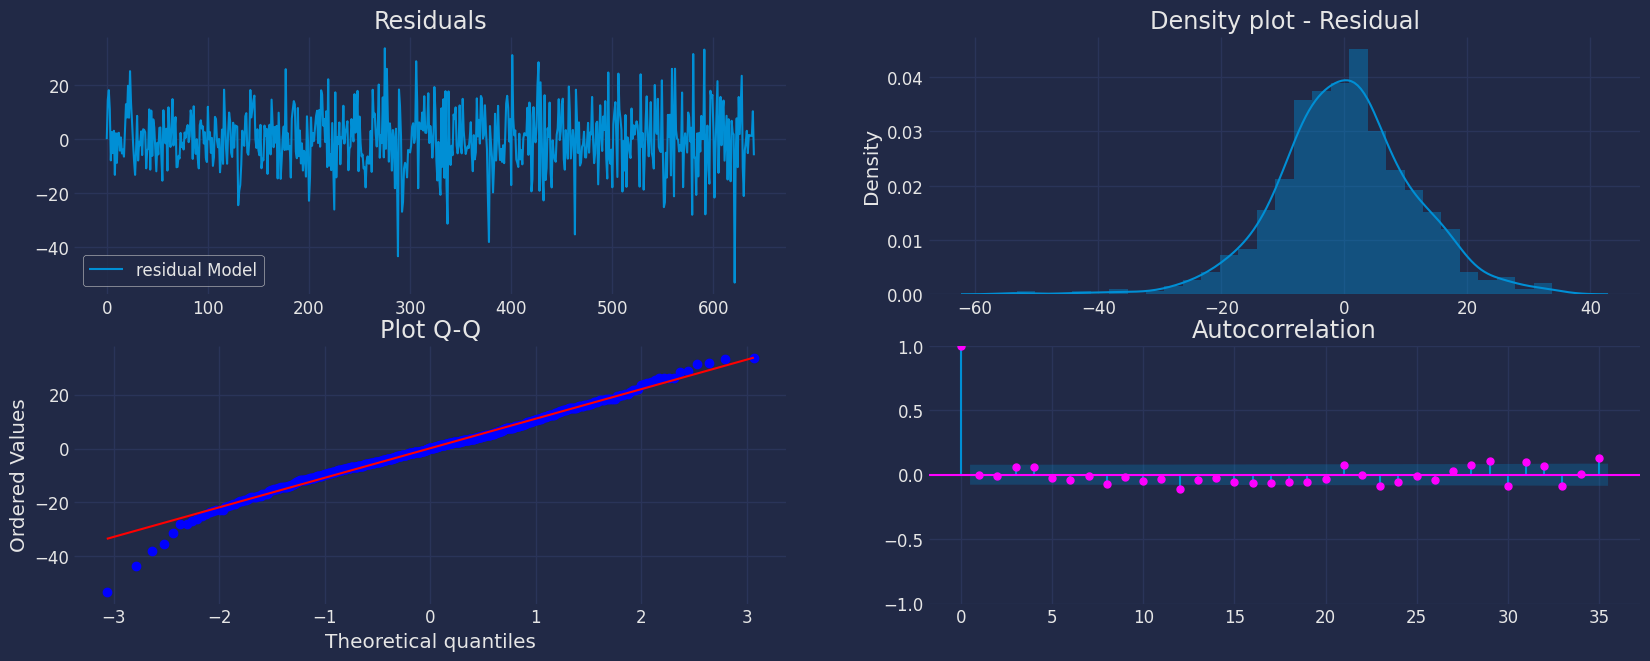

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

In [126]:
Y_hat_df = sf.forecast(df=Y_train_df, h=87, fitted=True)
Y_hat_df.head()

,unique_id,ds,AutoARIMA
0,1,2019-01-02,151.587906
1,1,2019-01-03,141.664658
2,1,2019-01-04,150.941696
3,1,2019-01-05,147.718353
4,1,2019-01-06,140.536728


In [112]:
values=sf.forecast_fitted_values()
values

,unique_id,ds,y,AutoARIMA
0,1,2017-04-01,30.0,29.970146
1,1,2017-04-02,45.0,44.955292
2,1,2017-04-03,65.0,64.935440
3,1,2017-04-04,78.0,77.922585
4,1,2017-04-05,71.0,70.929733
...,...,...,...,...
636,1,2018-12-28,146.0,147.975677
637,1,2018-12-29,144.0,143.649918
638,1,2018-12-30,143.0,138.927780
639,1,2018-12-31,155.0,152.734436


In [113]:
sf.forecast(df=Y_train_df, h=87, level=[95])

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,1,2019-01-02,152.861816,132.866104,172.857529
1,1,2019-01-03,149.035110,120.187874,177.882339
2,1,2019-01-04,149.988037,114.309509,185.666580
3,1,2019-01-05,146.986588,105.355431,188.617737
4,1,2019-01-06,142.160416,94.987015,189.333817
...,...,...,...,...,...
82,1,2019-03-25,174.858887,93.785919,255.931839
83,1,2019-03-26,180.260376,99.142281,261.378479
84,1,2019-03-27,181.299484,100.090546,262.508423
85,1,2019-03-28,176.320389,95.028191,257.612579


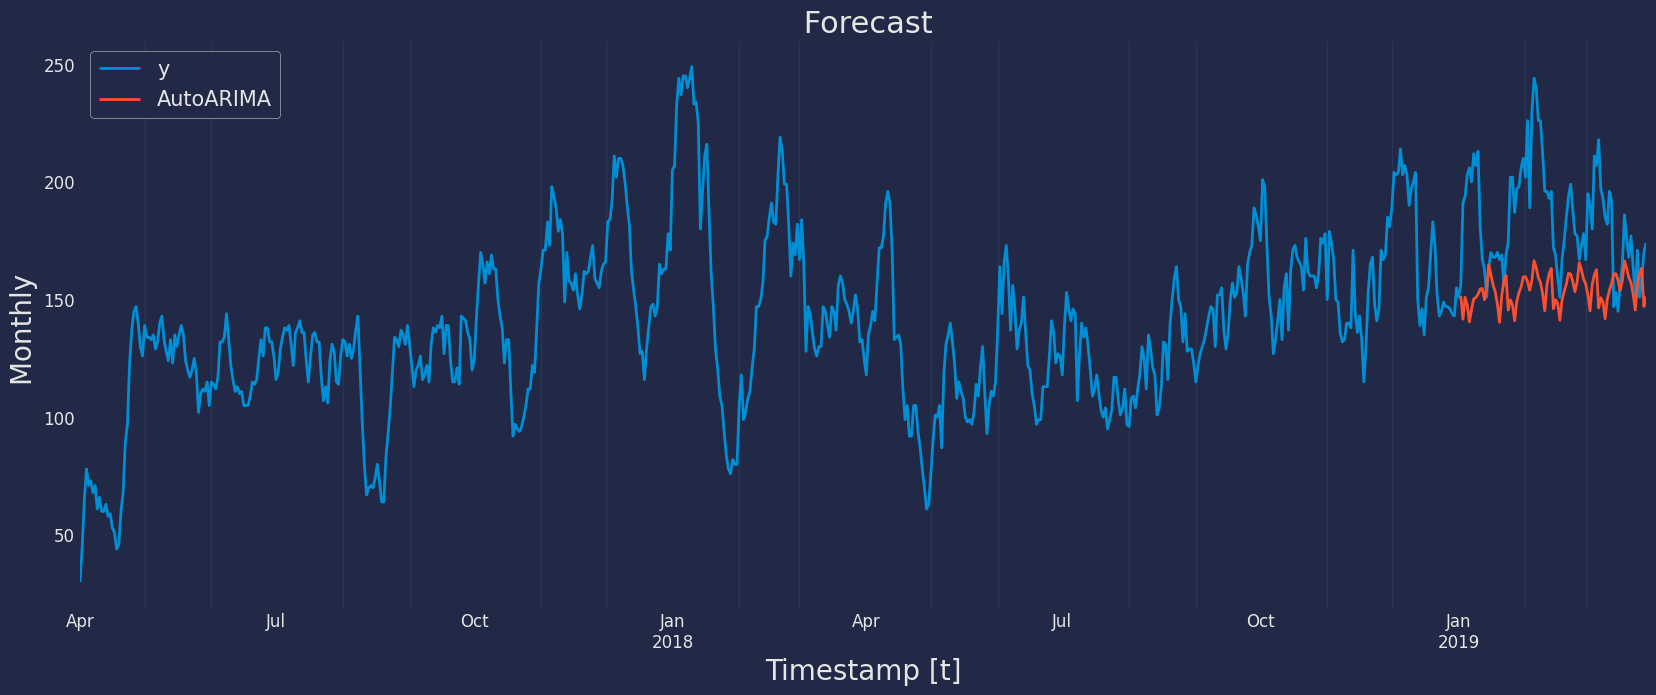

In [127]:
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Monthly ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()